In [244]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching wheat data from yahoo finance
data = yf.Ticker('ZW=F')
data = yf.download('ZW=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-07-17,248.00,248.00,243.75,244.00,244.00,7233
1,2000-07-18,244.25,247.50,241.00,241.25,241.25,6523
2,2000-07-19,241.25,246.00,239.00,245.00,245.00,7136
3,2000-07-20,244.00,247.50,244.00,247.00,247.00,3792
4,2000-07-21,247.00,248.50,246.50,247.25,247.25,4380
...,...,...,...,...,...,...,...
5901,2024-03-08,528.50,528.50,526.75,526.75,526.75,15
5902,2024-03-11,526.75,537.50,526.00,537.50,537.50,25
5903,2024-03-12,541.00,544.75,535.50,535.50,535.50,40
5904,2024-03-13,534.50,535.25,532.25,532.25,532.25,40


In [245]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-07-17,244.00
1,2000-07-18,241.25
2,2000-07-19,245.00
3,2000-07-20,247.00
4,2000-07-21,247.25
...,...,...
5901,2024-03-08,526.75
5902,2024-03-11,537.50
5903,2024-03-12,535.50
5904,2024-03-13,532.25


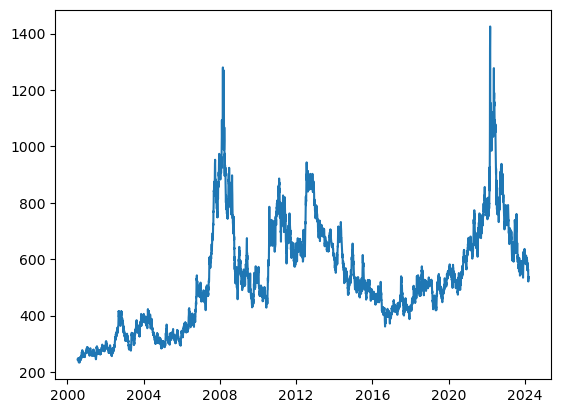

In [246]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [247]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [248]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-07-26,244.25,245.50,245.50,247.25,247.00,245.00,241.25,244.00
2000-07-27,245.75,244.25,245.50,245.50,247.25,247.00,245.00,241.25
2000-07-28,248.50,245.75,244.25,245.50,245.50,247.25,247.00,245.00
2000-07-31,246.00,248.50,245.75,244.25,245.50,245.50,247.25,247.00
2000-08-01,245.00,246.00,248.50,245.75,244.25,245.50,245.50,247.25
...,...,...,...,...,...,...,...,...
2024-03-08,526.75,520.75,521.25,545.75,563.50,560.00,577.50,571.00
2024-03-11,537.50,526.75,520.75,521.25,545.75,563.50,560.00,577.50
2024-03-12,535.50,537.50,526.75,520.75,521.25,545.75,563.50,560.00


In [249]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[244.25, 245.5 , 245.5 , ..., 245.  , 241.25, 244.  ],
       [245.75, 244.25, 245.5 , ..., 247.  , 245.  , 241.25],
       [248.5 , 245.75, 244.25, ..., 247.25, 247.  , 245.  ],
       ...,
       [535.5 , 537.5 , 526.75, ..., 545.75, 563.5 , 560.  ],
       [532.25, 535.5 , 537.5 , ..., 521.25, 545.75, 563.5 ],
       [534.75, 532.25, 535.5 , ..., 520.75, 521.25, 545.75]])

In [250]:
shifted_df_as_np.shape

(5899, 8)

In [251]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9819593 , -0.97986155, -0.97986155, ..., -0.98070065,
        -0.98699392, -0.98237885],
       [-0.979442  , -0.9819593 , -0.97986155, ..., -0.97734424,
        -0.98070065, -0.98699392],
       [-0.97482694, -0.979442  , -0.9819593 , ..., -0.97692469,
        -0.97734424, -0.98070065],
       ...,
       [-0.49318229, -0.48982589, -0.50786658, ..., -0.4759807 ,
        -0.44619257, -0.45206629],
       [-0.49863646, -0.49318229, -0.48982589, ..., -0.51709671,
        -0.4759807 , -0.44619257],
       [-0.49444095, -0.49863646, -0.49318229, ..., -0.51793581,
        -0.51709671, -0.4759807 ]])

In [252]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5899, 7), (5899,))

In [253]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98237885, -0.98699392, -0.98070065, ..., -0.97692469,
        -0.97986155, -0.97986155],
       [-0.98699392, -0.98070065, -0.97734424, ..., -0.97986155,
        -0.97986155, -0.9819593 ],
       [-0.98070065, -0.97734424, -0.97692469, ..., -0.97986155,
        -0.9819593 , -0.979442  ],
       ...,
       [-0.45206629, -0.44619257, -0.4759807 , ..., -0.51793581,
        -0.50786658, -0.48982589],
       [-0.44619257, -0.4759807 , -0.51709671, ..., -0.50786658,
        -0.48982589, -0.49318229],
       [-0.4759807 , -0.51709671, -0.51793581, ..., -0.48982589,
        -0.49318229, -0.49863646]])

In [254]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5604

In [255]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5604, 7), (295, 7), (5604,), (295,))

In [256]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5604, 7, 1), (295, 7, 1), (5604, 1), (295, 1))

In [257]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5604, 7, 1]),
 torch.Size([295, 7, 1]),
 torch.Size([5604, 1]),
 torch.Size([295, 1]))

In [258]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [259]:
train_dataset

In [260]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [261]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [262]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
#model = LSTM(1, 4, 1) MSE: 2.41
#model = LSTM(1, 8, 2) MSE: 2.19
#model = LSTM(1, 16, 4) MSE: 3.10
#model = LSTM(1, 12, 4) MSE: 2.62
#model = LSTM(1, 8, 4) MSE: 2.67
#model = LSTM(1, 8, 8) MSE: 4.007
model = LSTM(1, 4, 2) #MSE: 2.019
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [263]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [264]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [265]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.369
Batch 200, Loss: 0.102
Batch 300, Loss: 0.065

Val Loss: 0.002
***************************************************

Epoch: 2
Batch 100, Loss: 0.008
Batch 200, Loss: 0.008
Batch 300, Loss: 0.009

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005
Batch 300, Loss: 0.004

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
*****************

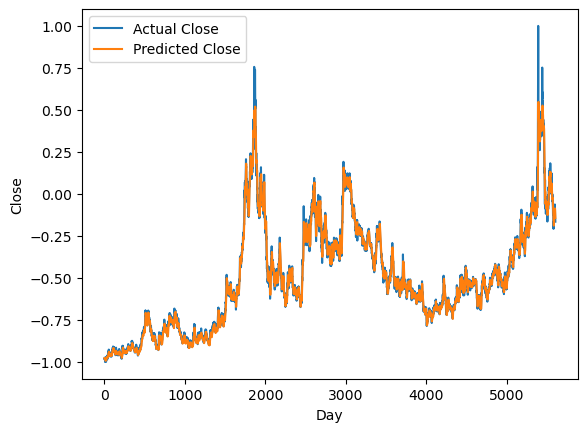

In [266]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [267]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([246.5565517 , 246.30750708, 246.28754657, ..., 757.14821792,
       749.67770044, 744.34156769])

In [268]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([244.25001203, 245.74999802, 248.50000192, ..., 743.5000032 ,
       741.50000117, 731.0000016 ])

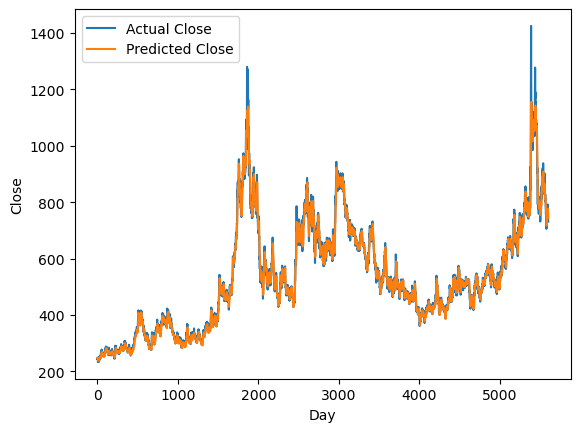

In [269]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [270]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([738.12351435, 736.18457478, 736.769716  , 738.1674843 ,
       741.64645518, 741.87850496, 738.91983917, 738.11783165,
       731.67250556, 730.08550312, 732.09080606, 737.72631091,
       741.89281828, 745.22641842, 749.89245348, 753.09936477,
       755.2667092 , 755.27260501, 752.80670537, 750.34836639,
       753.02840197, 753.90616708, 762.70167869, 772.55749016,
       778.01183209, 775.79491937, 771.07422377, 767.17141175,
       760.20190923, 750.34948518, 743.32599694, 730.30036272,
       716.2251503 , 704.70372857, 698.86314904, 697.49068655,
       696.10105162, 691.31445438, 687.83857347, 682.66050877,
       672.5119047 , 667.93398711, 667.68167493, 672.82917733,
       682.57042011, 689.47313306, 697.02062014, 699.59593409,
       695.00853348, 684.2457176 , 674.60532511, 675.75277017,
       682.08802933, 688.43678492, 694.44781014, 694.9598753 ,
       693.93613566, 693.06007537, 691.82614662, 688.16168863,
       683.12798244, 680.10906219, 677.20360074, 676.78

In [271]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([739.99999743, 742.75000133, 743.74999791, 751.74999716,
       742.49999775, 734.4999985 , 741.50000117, 720.00000374,
       734.4999985 , 741.24999759, 752.49999903, 749.99999871,
       752.49999903, 761.25000015, 759.75000084, 761.000001  ,
       756.7499978 , 750.25000229, 749.750004  , 764.75000149,
       757.25000052, 785.99999977, 792.00000143, 785.99999977,
       769.2499994 , 765.00000063, 765.49999892, 750.499997  ,
       736.50000053, 738.24999898, 708.25000401, 695.99999711,
       691.50000364, 697.00000257, 701.25000134, 695.75000241,
       682.49999894, 684.74999567, 674.49999969, 653.50000055,
       666.74999514, 672.25000295, 686.500003  , 702.7499962 ,
       698.99999572, 710.50000075, 700.75000305, 683.25000081,
       663.50000183, 661.99999809, 688.49999615, 697.99999915,
       699.7499976 , 704.74999824, 692.24999663, 692.24999663,
       693.49999679, 691.50000364, 682.00000065, 675.49999626,
       678.50000375, 673.99999252, 679.50000033, 666.99

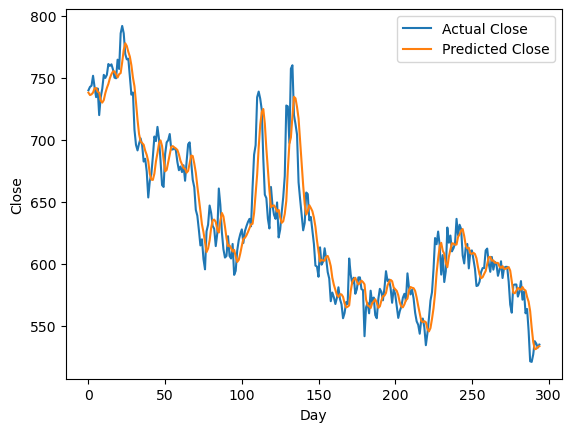

In [272]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [273]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 18.71104806864937
Mean Absolute Error (MAE): 13.987734205575691
Mean Absolute Percentage Error (MAPE): 2.196423356526602


In [274]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.031, MAE: 0.020, MAPE: 18.109%
Validation - RMSE: 0.031, MAE: 0.023, MAPE: 9.063%


In [275]:
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
prediction = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted wheat price for tomorrow: {prediction}')


Predicted oil price for tomorrow: 531.1849747151136
